# VQE tutorial: Harmonic Oscillator in the Finite Difference Basis

In this tutorial, we describe the calculation of the ground state energy of the harmonic oscillator. Before one can set up the calculation to compute the ground state energies using the VQE, one needs to perform a Hamiltonian mapping in terms of qubits. The first step is to represent the Hamiltonian as an $N \times N $ matrix using a discete quantum mechanics approximation to the quantum mechanical operators which would be infinite dimensional for bosonic observables. For more information, please check the paper [here](https://arxiv.org/abs/2102.05102).

## Finite Difference basis

This is the type of basis that comes up when realized differential equations in terms of finite difference equations. In this case the position operator is again diagonal but the momentum operator, although not diagonal, is still sparse. In the finite difference basis the position matrix is:
$${\left( {{X_{fd}}} \right)_{j,k}} = \sqrt {\frac{1}{{2N}}} (2j - (N + 1)){\delta _{j,k}}$$
and the momentum-squared matrix is:

\begin{equation} 
P_{fd}^2 = \frac{N}{2}
\begin{bmatrix}
2 & - 1  & 0 &  \cdots  & 0  \\ 
-1 & 2 & -1 &  \cdots  & 0  \\ 
0 & -1 &  \ddots  &  \ddots  & 0  \\ 
0 & 0 &  \ddots  & 2 & -1  \\ 
0 & 0 &  \cdots  & -1 & 2  \\ 
\end{bmatrix}
\end{equation}

The simple harmonic Hamiltonian is then:
\begin{equation}
H=\frac{1}{2}P_{fd}^2 + \frac{1}{2}X_{fd}
\end{equation}

In [2]:
import numpy as np

# This is where you select the number of qubits for the simulation.
nqubits = 4;
n = 2**nqubits;

# This will aid in creating the momentum operator.
s = np.diagflat(np.ones((1,n)), k=0)
for row in range(0,n-1):
        s[row][row + 1] = -1

# Create the diagonal of the position operator.
xfd_diag = (2*np.linspace(1,n,n)-(n+1))/2

# Create the position operator as a diagonal matrix, with xfd_diag as its diagonal.
xfd = np.diagflat(xfd_diag, k = 0)

# Create the momentum operator
pfd = s + np.transpose(s)

# This is where you input the desired potential. The @ symbol represents matrix multiplication 
# (It's the same as using np.matmul()).
V = (1/2)*xfd @ xfd

# Create Hamiltonian
hamiltonian = (1/2)*(pfd @ pfd) + V

# Find exact eigenvalues and eigenvectors of Hamiltonian
val,vec=np.linalg.eig(hamiltonian)
z = np.argsort(val)
z = z[0:len(hamiltonian)]
energies=(val[z])

print(np.real(energies))

[ 0.48302298  1.68429679  3.17115899  4.70018978  6.27429234  7.36112757
  9.47131478  9.64833707 13.35632109 13.36207022 18.27575013 18.27583803
 24.18891291 24.18891375 31.27922678 31.27922679]


## Use QISKIT to solve the problem with quantum algorithms
### Convert the Hamiltonian
Now, we take the Hamiltonian matrix and map it onto a qubit operator. There are many ways in which this can be done. To use primitive operators, check the documentation [here](https://qiskit.org/documentation/apidoc/qiskit.aqua.operators.primitive_ops.html). For all other ways of mapping the Hamiltonian to a qubit operator, check the documentation [here](https://qiskit.org/documentation/apidoc/qiskit.aqua.operators.html).

In [3]:
# Convert the Hamiltonian Matrix to a qubit operator.

import warnings
import time

from qiskit.aqua.operators import MatrixOp

start_time = time.time()
warnings.filterwarnings("ignore")

# Map the Hamiltonian to a matrix operator. This is fast when working with statevector simulators, but may not work
# on an actual quantum computer. For that, PauliOp() or legacy operators may be used.
qubitOp_Matrix = MatrixOp(primitive=hamiltonian)

# To represent the Hamiltonian as a decomposed string of summed Pauli operators 
# (or summed tensor products of Pauli operators), use the to_pauli_op() method of the MatrixOp class.
qubitOp = qubitOp_Matrix.to_pauli_op()

print("Size of Hamiltonian:", np.shape(hamiltonian))
print(qubitOp)

# You can print the type of the qubit operator with the next line. This can help when checking for bugs.
#print(type(qubitOp))

end_time = time.time()

runtime = end_time-start_time
print('Program runtime: ',runtime)

Size of Hamiltonian: (16, 16)
SummedOp(
[13.5625 * IIII,
-2.0 * IIIX,
0.5 * IIXI,
-1.0 * IIXX,
-1.0 * IIYY,
0.4375 * IIZZ,
0.25 * IXXI,
-0.5 * IXXX,
0.5 * IXYY,
-0.5 * IYXY,
0.25 * IYYI,
-0.5 * IYYX,
0.9375 * IZIZ,
1.9375 * IZZI,
0.125 * XXXI,
-0.25 * XXXX,
0.25 * XXYY,
0.25 * XYXY,
-0.125 * XYYI,
0.25 * XYYX,
-0.25 * YXXY,
0.125 * YXYI,
-0.25 * YXYX,
0.125 * YYXI,
-0.25 * YYXX,
0.25 * YYYY,
1.9375 * ZIIZ,
3.9375 * ZIZI,
7.9375 * ZZII,
-0.0625 * ZZZZ])
Program runtime:  0.039140939712524414


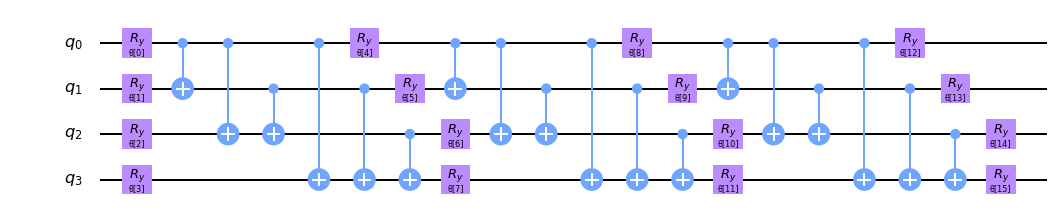

In [4]:
# Create the variational form.
from qiskit.circuit.library import EfficientSU2

var_form = EfficientSU2(qubitOp.num_qubits, su2_gates=['ry'], entanglement="full", reps=3)
display(var_form.draw(output='mpl',fold=100))

In the next cell, we check the exact minimum eigenvalue of the qubit operator to make sure that our Hamiltonian mapped correctly. __Note__: This next cell will not work for matrix operators. If you mapped your Hamiltonian using MatrixOp(), do not run this next cell, as it will only give an error.

In [5]:
from qiskit.aqua.algorithms import NumPyEigensolver

# Find the exact ground state eigenvalue of the qubit operator. Make sure that this result matches the previous
# ground state eigenvalue of the Hamiltonian above. This makes sure that everything went smoothly when
# converting the Hamiltonian to a qubit operator.

exact_solution = NumPyEigensolver(qubitOp).run()
print("Exact Result:", np.real(exact_solution.eigenvalues))

Exact Result: [0.48302298]


## Looping the VQE algorithm over several optimizers

The following cell runs the VQE algorithm multiple times in a for loop, each time with a different optimizer. You can use this to see which optimizer is the best for the Hamiltonian that you're running. For statevector simulators, in my experience, SLSQP is the best optimizer. But as you will see, for these quartic Hamiltonians, sometimes, the COBYLA actually converges the quickest, usually with a slightly more accurate result. If you are only interested in using a single optimizer (since looping the vqe will take substaintially longer run times), you can remove the for loop then replace the optimizer in the VQE class instantiation with any of the elements of the optimizer list (e.g., if you want to run SLSQP, instatiate the VQE class with optimizerList[0]). Note that for QASM simulators or running on real devices, the SPSA optimizer is the best. Also note that sometimes, the optimizers may not converge on the correct result, and you may have to run the vqe algorithm again to see what the result is on average.

#### Statevector simulator

Example from [here](https://qiskit.org/documentation/tutorials/algorithms/02_vqe_convergence.html)

In [6]:
# This is a callback function that will allow us to store information about the optimizer while the VQE is running.
# This is called when instantiating an object of the VQE class.

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

In [7]:
from qiskit.aqua.algorithms import VQE
from qiskit import BasicAer
from qiskit.aqua.components.optimizers import SLSQP, COBYLA, L_BFGS_B, NELDER_MEAD

start_time = time.time()
warnings.filterwarnings("ignore")
backend = BasicAer.get_backend("statevector_simulator")

# Lists that hold the number of optimizer evalutions and the value at each evaluation
countArr = []
valArr = []

# List that holds the VQE result for each optimizer
vqe_result = []

# List that holds the optimally parametrized variational form (see next section on plotting the wave function)
qc = []

optimizerList = [SLSQP(maxiter=3000), COBYLA(maxiter=4000), L_BFGS_B(maxfun=5000, maxiter=20000), NELDER_MEAD(maxfev=4000)]

for optimizer in optimizerList:

    counts = []
    values = []

    countArr.append(counts)
    valArr.append(values)

    vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
    ret = vqe.run(backend)
    vqe_result.append(np.real(ret['eigenvalue']))
    qc.append(vqe.get_optimal_circuit())

print("VQE Result:", vqe_result)

end_time = time.time()
runtime = end_time-start_time
print('Program runtime:',runtime, "s")

VQE Result: [0.483084708883, 0.48320967274031, 0.48302299324298, 0.58412512324245]
Program runtime: 40.18867778778076 s


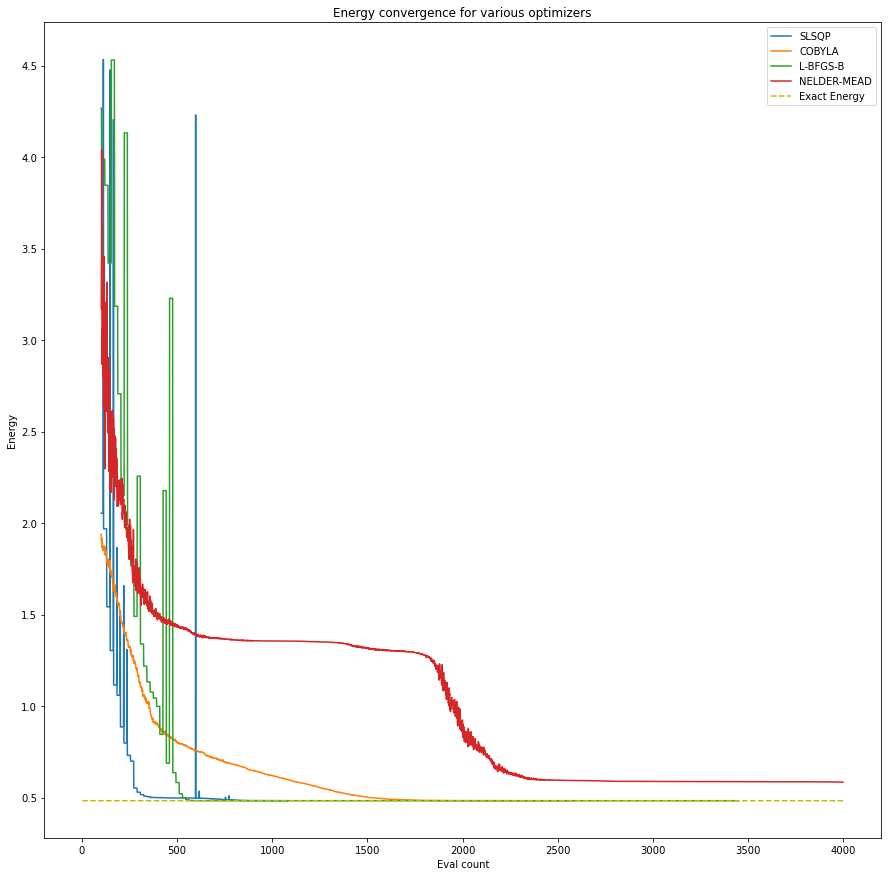

In [8]:
import matplotlib.pyplot as plt

# Plot all of the optimizers in a single convergence plot. If you see that the optimizer isn't converging,
# increase the maximum iterations or maximum function evaluations in the optimizer list above.

labelList = ["SLSQP", "COBYLA", "L-BFGS-B", "NELDER-MEAD"]

plt.figure(figsize=(15,15))

for i in range(0,len(optimizerList)):
    # Limit the range of the plot in order to make the convergence of each optimizer more visible.
    plt.plot(countArr[i][100:len(countArr[i])-1], valArr[i][100:len(valArr[i])-1], label=labelList[i])

plt.plot(countArr[3],[np.real(energies[0])]*len(countArr[3]), 'y--',label="Exact Energy")
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence for various optimizers')
plt.legend(loc='upper right')

# Plotting the Resulting Wave Function
This next cell plots the wavefunction. If the Hamiltonian was in the position basis, then the x-axis should be position. This is how it works:

Notice the circuit that you create with the variational form. It has a bunch of Ry gates that all have the parameter theta in them. The Ry gate's purpose is to rotate the qubit's Bloch vector about the y-axis of the Bloch sphere by a certain angle (that angle is represented by theta). The purpose of VQE is to find all of the thetas for each Ry gate in the variational form which minimizes the eigenvalue. When the algorithm is finished running, vqe.get_optimal_circuit() allows you to obtain the variational form, but this time, all of those thetas have been filled in with the optimal angle that the VQE found. Remember, the variational form is the ansatz ground state wavefunction. This means that vqe.get_optimal_circuit() is a circuit that represents a state for which the expectation value of the Hamiltonian is minimized when measured in that state (i.e. this is the state with minimum energy).

In order to plot this wave function, we have to run a statevector simulation on the circuit. What happens here is that you simulate what the statevector is at each position (for more about statevectors, check chapter 1.3 of the qiskit textbook). Plotting the results gives the wave function.

For more about Bloch spheres and Ry gates, check chapters 1.3 and 1.4, respectively. 

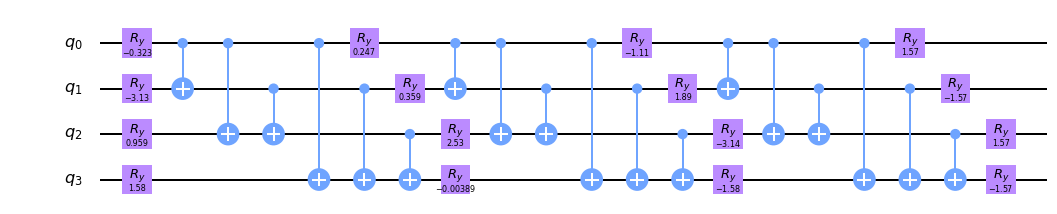

<function matplotlib.pyplot.show(*args, **kw)>

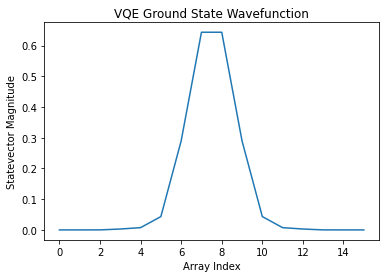

In [10]:
from qiskit import QuantumCircuit, execute

# Find the index of the minimum VQE result from the list of VQE results
best_vqeResult = vqe_result.index(min(vqe_result))

# We will plot the wave function of the best VQE result. To do this, obtain the optimal circuit.
qc_optimal = qc[best_vqeResult]

# Display the optimal circuit. Notice that this is the variational form, but this time,
# the thetas are filled out with numbers.
display(qc_optimal.draw(output='mpl',fold=100))

# Run the statevector simulation on the circuit
qcBackend = BasicAer.get_backend('statevector_simulator')
result = execute(qc_optimal,qcBackend,shots = 1024).result() 
outPut_state = result.get_statevector()

# Display the statevector
plt.plot(abs(outPut_state))
plt.xlabel('Array Index')
plt.ylabel('Statevector Magnitude')
plt.title("VQE Ground State Wavefunction")
plt.show

#### QASM simulator

Example from [here](https://qiskit.org/documentation/tutorials/algorithms/03_vqe_simulation_with_noise.html#Performance-without-noise)

In [ ]:
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua import QuantumInstance


start_time = time.time()
warnings.filterwarnings("ignore")

backendQasm = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend=backendQasm, shots=200)
optimizerQasm = SPSA(max_trials=1000)

counts = []
values = []

# Run the VQE
vqe = VQE(qubitOp, var_form, optimizerQasm, callback=store_intermediate_result)
ret = vqe.run(quantum_instance)
vqe_result = np.real(ret['eigenvalue'])
print("VQE Result:", vqe_result)
end_time = time.time()

runtime = end_time-start_time
print('Program runtime:',runtime, "s")

In [ ]:
# Plot convergence plot for the SPSA optimizer
plt.figure(figsize=(15,15))
plt.plot(counts, values, label="SPSA")
plt.plot(counts,[np.real(energies[0])]*len(counts), 'y--',label="Exact Energy")
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence of SPSA optimizer For Qasm Simulation')
plt.legend(loc='upper right')